# MovieLens 25M Dataset Exploration

Real-Time Recommendation Engine Data Analysis


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
import warnings

In [2]:
warnings.filterwarnings("ignore")

Set plotting style


In [3]:
plt.style.use("default")
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 10

In [4]:
DATA_PATH = Path("../data/raw/ml-25m")
SAMPLE_SIZE = 100000

# 1.0 Data Loading


In [5]:
ratings = pd.read_csv(f"{DATA_PATH}/ratings.csv")
movies = pd.read_csv(f"{DATA_PATH}/movies.csv")
tags = pd.read_csv(f"{DATA_PATH}/tags.csv")
links = pd.read_csv(f"{DATA_PATH}/links.csv")

In [6]:
print(f"Ratings: {ratings.shape[0]:,} rows, {ratings.shape[1]} columns")
print(f"Movies: {movies.shape[0]:,} rows, {movies.shape[1]} columns")
print(f"Tags: {tags.shape[0]:,} rows, {tags.shape[1]} columns")
print(f"Links: {links.shape[0]:,} rows, {links.shape[1]} columns")

Ratings: 25,000,095 rows, 4 columns
Movies: 62,423 rows, 3 columns
Tags: 1,093,360 rows, 4 columns
Links: 62,423 rows, 3 columns


In [7]:
try:
    genome_scores = pd.read_csv(f"{DATA_PATH}/genome-scores.csv")
    genome_tags = pd.read_csv(f"{DATA_PATH}/genome-tags.csv")

    print(f"Genome score loaded: {genome_scores.shape[0]:,} rows")
    print(f"Genome tags loaded: {genome_tags.shape[0]:,} rows")

    has_genome = True

except FileNotFoundError:
    print("Genome data not found (optional data)")
    has_genome = False

Genome score loaded: 15,584,448 rows
Genome tags loaded: 1,128 rows


## 2.0 Data Overview


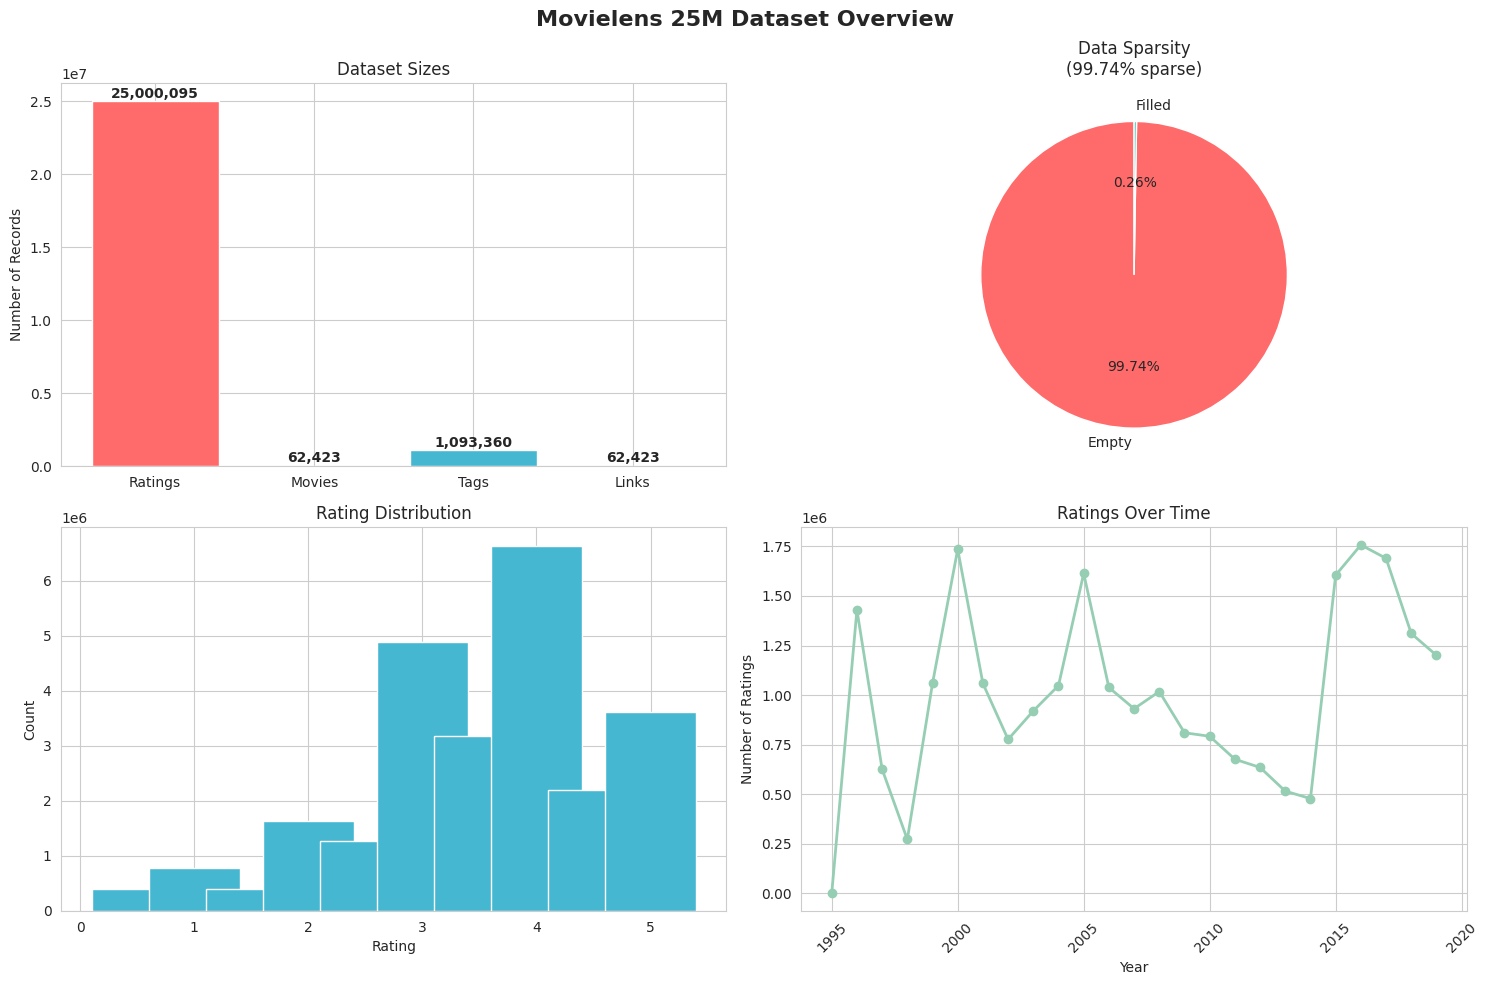

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Movielens 25M Dataset Overview", fontsize=16, fontweight="bold")

# 1. Dataset sizes visualization
dataset_sizes = [ratings.shape[0], movies.shape[0], tags.shape[0], links.shape[0]]
dataset_names = ["Ratings", "Movies", "Tags", "Links"]
colors = ["#ff6b6b", "#4ecdc4", "#45b7d1", "#96ceb4"]

axes[0, 0].bar(dataset_names, dataset_sizes, color=colors)
axes[0, 0].set_title("Dataset Sizes")
axes[0, 0].set_ylabel("Number of Records")

for i, v in enumerate(dataset_sizes):
    axes[0, 0].text(
        i, v + max(dataset_sizes) * 0.01, f"{v:,}", ha="center", fontweight="bold"
    )

# 2. Basic stats
unique_users = ratings["userId"].nunique()
unique_movies = ratings["movieId"].nunique()
total_possible_ratings = unique_users * unique_movies
sparsity = 1 - (ratings.shape[0] / total_possible_ratings)

axes[0, 1].pie(
    [sparsity, 1 - sparsity],
    labels=["Empty", "Filled"],
    colors=["#ff6b6b", "#4ecdc4"],
    autopct="%1.2f%%",
    startangle=90,
)
axes[0, 1].set_title(f"Data Sparsity\n({sparsity*100:.2f}% sparse)")

# 3. Rating distribution
rating_counts = ratings["rating"].value_counts().sort_index()
axes[1, 0].bar(rating_counts.index, rating_counts.values, color="#45b7d1")
axes[1, 0].set_title("Rating Distribution")
axes[1, 0].set_xlabel("Rating")
axes[1, 0].set_ylabel("Count")

# 4. Basic timeline
ratings["datetime"] = pd.to_datetime(ratings["timestamp"], unit="s")
yearly_counts = ratings.groupby(ratings["datetime"].dt.year).size()
axes[1, 1].plot(
    yearly_counts.index, yearly_counts.values, marker="o", color="#96ceb4", linewidth=2
)
axes[1, 1].set_title("Ratings Over Time")
axes[1, 1].set_xlabel("Year")
axes[1, 1].set_ylabel("Number of Ratings")
axes[1, 1].tick_params(axis="x", rotation=45)


plt.tight_layout()
plt.show()

In [9]:
print(f"📊 Key Statistics:")
print(f"  • Total ratings: {ratings.shape[0]:,}")
print(f"  • Unique users: {unique_users:,}")
print(f"  • Unique movies: {unique_movies:,}")
print(f"  • Sparsity: {sparsity:.4f} ({sparsity*100:.2f}%)")
print(
    f"  • Time span: {ratings['datetime'].min().date()} to {ratings['datetime'].max().date()}"
)

📊 Key Statistics:
  • Total ratings: 25,000,095
  • Unique users: 162,541
  • Unique movies: 59,047
  • Sparsity: 0.9974 (99.74%)
  • Time span: 1995-01-09 to 2019-11-21


## 3.0 User Behavior Analysis


In [10]:
ratings_sample = ratings.sample(n=min(SAMPLE_SIZE, len(ratings)), random_state=42)

In [11]:
user_stats = (
    ratings_sample.groupby("userId")
    .agg({"rating": ["count", "mean", "std"], "timestamp": ["min", "max"]})
    .round(2)
)

In [12]:
user_stats.columns = [
    "num_ratings",
    "avg_rating",
    "rating_std",
    "first_rating",
    "last_rating",
]

user_stats["rating_span_days"] = (
    user_stats["last_rating"] - user_stats["first_rating"]
) / (24 * 3600)

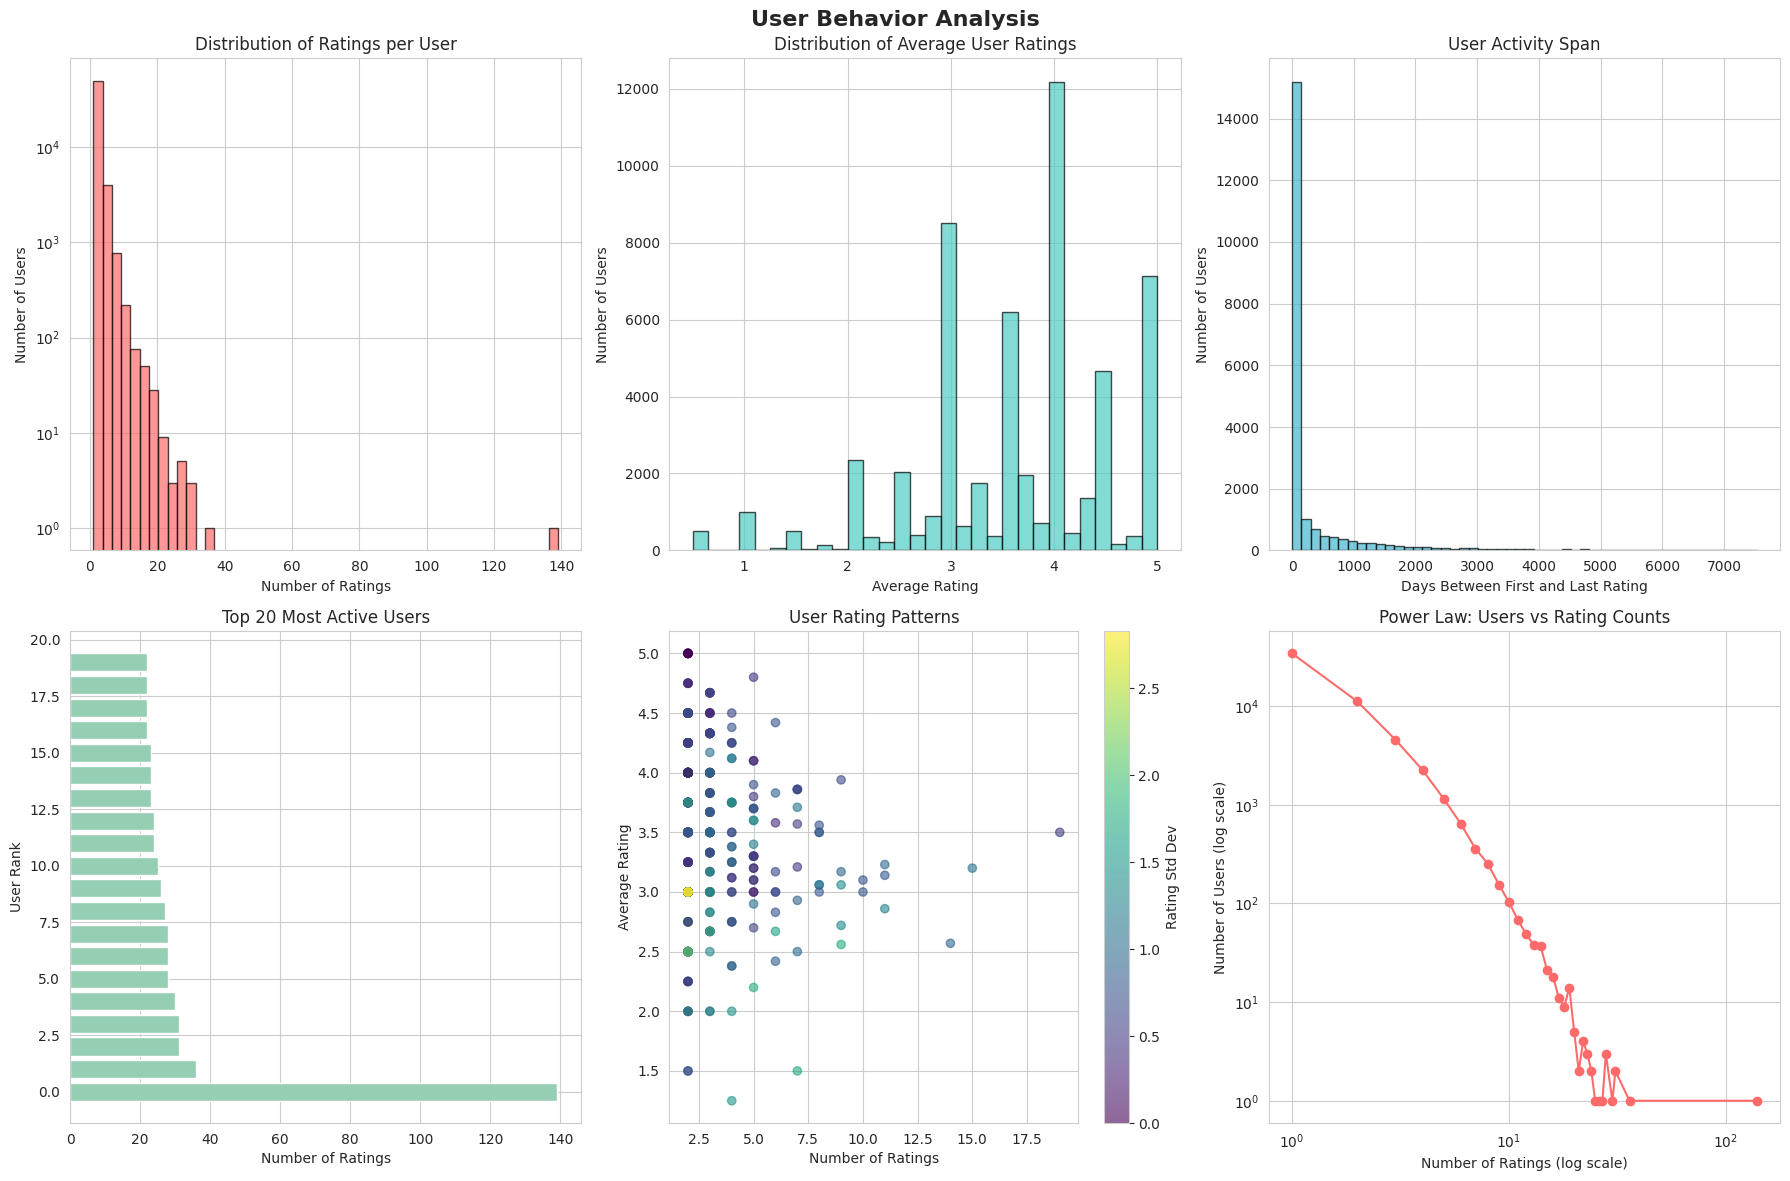

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("User Behavior Analysis", fontsize=16, fontweight="bold")

# 1. Number of ratings per user (histogram)
axes[0, 0].hist(
    user_stats["num_ratings"], bins=50, alpha=0.7, color="#ff6b6b", edgecolor="black"
)
axes[0, 0].set_title("Distribution of Ratings per User")
axes[0, 0].set_xlabel("Number of Ratings")
axes[0, 0].set_ylabel("Number of Users")
axes[0, 0].set_yscale("log")

# 2. Average rating per user
axes[0, 1].hist(
    user_stats["avg_rating"].dropna(),
    bins=30,
    alpha=0.7,
    color="#4ecdc4",
    edgecolor="black",
)
axes[0, 1].set_title("Distribution of Average User Ratings")
axes[0, 1].set_xlabel("Average Rating")
axes[0, 1].set_ylabel("Number of Users")

# 3. User activity span
valid_spans = user_stats["rating_span_days"][user_stats["rating_span_days"] > 0]
axes[0, 2].hist(valid_spans, bins=50, alpha=0.7, color="#45b7d1", edgecolor="black")
axes[0, 2].set_title("User Activity Span")
axes[0, 2].set_xlabel("Days Between First and Last Rating")
axes[0, 2].set_ylabel("Number of Users")

# 4. Top 20 most active users
top_users = user_stats.nlargest(20, "num_ratings")
axes[1, 0].barh(range(len(top_users)), top_users["num_ratings"], color="#96ceb4")
axes[1, 0].set_title("Top 20 Most Active Users")
axes[1, 0].set_xlabel("Number of Ratings")
axes[1, 0].set_ylabel("User Rank")

# 5. User rating behavior scatter
sample_users = user_stats.sample(min(1000, len(user_stats)), random_state=42)
scatter = axes[1, 1].scatter(
    sample_users["num_ratings"],
    sample_users["avg_rating"],
    alpha=0.6,
    c=sample_users["rating_std"],
    cmap="viridis",
)
axes[1, 1].set_title("User Rating Patterns")
axes[1, 1].set_xlabel("Number of Ratings")
axes[1, 1].set_ylabel("Average Rating")
plt.colorbar(scatter, ax=axes[1, 1], label="Rating Std Dev")

# 6. Power law distribution
user_rating_counts = user_stats["num_ratings"].value_counts().sort_index()
axes[1, 2].loglog(
    user_rating_counts.index, user_rating_counts.values, "o-", color="#ff6b6b"
)
axes[1, 2].set_title("Power Law: Users vs Rating Counts")
axes[1, 2].set_xlabel("Number of Ratings (log scale)")
axes[1, 2].set_ylabel("Number of Users (log scale)")

plt.tight_layout()
plt.show()

In [14]:
print(f"📊 User Behavior Summary:")
print(f"  • Average ratings per user: {user_stats['num_ratings'].mean():.1f}")
print(f"  • Median ratings per user: {user_stats['num_ratings'].median():.1f}")
print(f"  • Users with 1 rating: {len(user_stats[user_stats['num_ratings'] == 1]):,}")
print(
    f"  • Users with 50+ ratings: {len(user_stats[user_stats['num_ratings'] >= 50]):,}"
)

📊 User Behavior Summary:
  • Average ratings per user: 1.8
  • Median ratings per user: 1.0
  • Users with 1 rating: 34,159
  • Users with 50+ ratings: 1


## 4.0 Movie Popularity


In [15]:
movie_stats = (
    ratings_sample.groupby("movieId")
    .agg({"rating": ["count", "mean", "std"], "userId": "nunique"})
    .round(2)
)

In [16]:
movie_stats.columns = ["num_ratings", "avg_rating", "rating_std", "unique_users"]
movie_stats_with_titles = movie_stats.merge(movies[["movieId", "title"]], on="movieId")

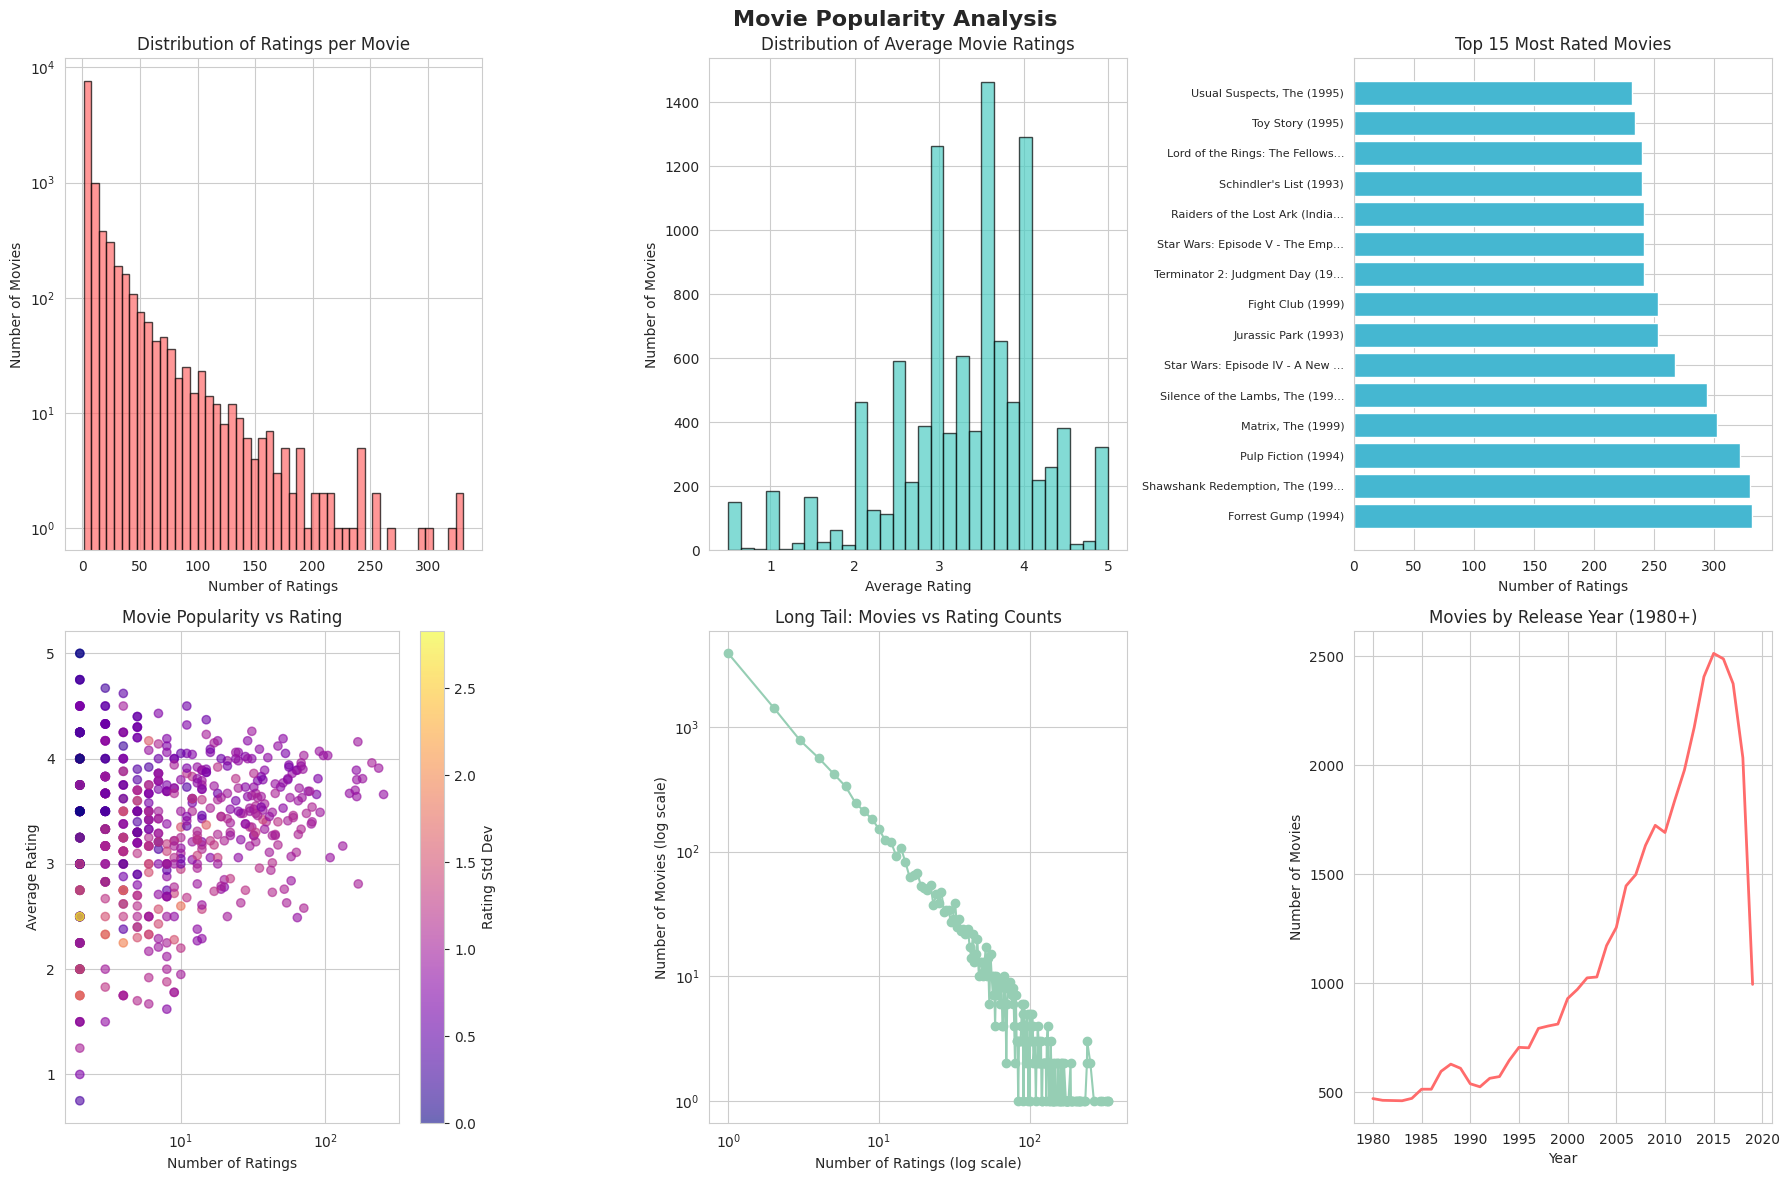

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("Movie Popularity Analysis", fontsize=16, fontweight="bold")

# 1. Movie popularity distribution
axes[0, 0].hist(
    movie_stats["num_ratings"], bins=50, alpha=0.7, color="#ff6b6b", edgecolor="black"
)

axes[0, 0].set_title("Distribution of Ratings per Movie")
axes[0, 0].set_xlabel("Number of Ratings")
axes[0, 0].set_ylabel("Number of Movies")
axes[0, 0].set_yscale("log")

# 2. Average movie ratings
axes[0, 1].hist(
    movie_stats["avg_rating"].dropna(),
    bins=30,
    alpha=0.7,
    color="#4ecdc4",
    edgecolor="black",
)

axes[0, 1].set_title("Distribution of Average Movie Ratings")
axes[0, 1].set_xlabel("Average Rating")
axes[0, 1].set_ylabel("Number of Movies")

# 3. Top 15 most popular movies
top_movies = movie_stats_with_titles.nlargest(15, "num_ratings")
axes[0, 2].barh(range(len(top_movies)), top_movies["num_ratings"], color="#45b7d1")

axes[0, 2].set_title("Top 15 Most Rated Movies")
axes[0, 2].set_xlabel("Number of Ratings")
axes[0, 2].set_yticks(range(len(top_movies)))
axes[0, 2].set_yticklabels(
    [title[:30] + "..." if len(title) > 30 else title for title in top_movies["title"]],
    fontsize=8,
)

# 4. Movie rating vs popularity scatter
sample_movies = movie_stats.sample(min(1000, len(movie_stats)), random_state=42)
scatter = axes[1, 0].scatter(
    sample_movies["num_ratings"],
    sample_movies["avg_rating"],
    alpha=0.6,
    c=sample_movies["rating_std"],
    cmap="plasma",
)

axes[1, 0].set_title("Movie Popularity vs Rating")
axes[1, 0].set_xlabel("Number of Ratings")
axes[1, 0].set_ylabel("Average Rating")
axes[1, 0].set_xscale("log")
plt.colorbar(scatter, ax=axes[1, 0], label="Rating Std Dev")

# 5. Long tail analysis
movie_rating_counts = movie_stats["num_ratings"].value_counts().sort_index()
axes[1, 1].loglog(
    movie_rating_counts.index, movie_rating_counts.values, "o-", color="#96ceb4"
)

axes[1, 1].set_title("Long Tail: Movies vs Rating Counts")
axes[1, 1].set_xlabel("Number of Ratings (log scale)")
axes[1, 1].set_ylabel("Number of Movies (log scale)")

# 6. Movie release year analysis
years = movies["title"].str.extract(r"\((\d{4})\)")[0].dropna().astype(int)
year_counts = years.value_counts().sort_index()
recent_years = year_counts[year_counts.index >= 1980]
axes[1, 2].plot(recent_years.index, recent_years.values, color="#ff6b6b", linewidth=2)

axes[1, 2].set_title("Movies by Release Year (1980+)")
axes[1, 2].set_xlabel("Year")
axes[1, 2].set_ylabel("Number of Movies")

plt.tight_layout()
plt.show()

## 5.0 Temporal Analysis


In [18]:
ratings_sample["datetime"] = pd.to_datetime(ratings_sample["timestamp"], unit="s")
ratings_sample["year"] = ratings_sample["datetime"].dt.year
ratings_sample["month"] = ratings_sample["datetime"].dt.month
ratings_sample["hour"] = ratings_sample["datetime"].dt.hour
ratings_sample["weekday"] = ratings_sample["datetime"].dt.day_name()

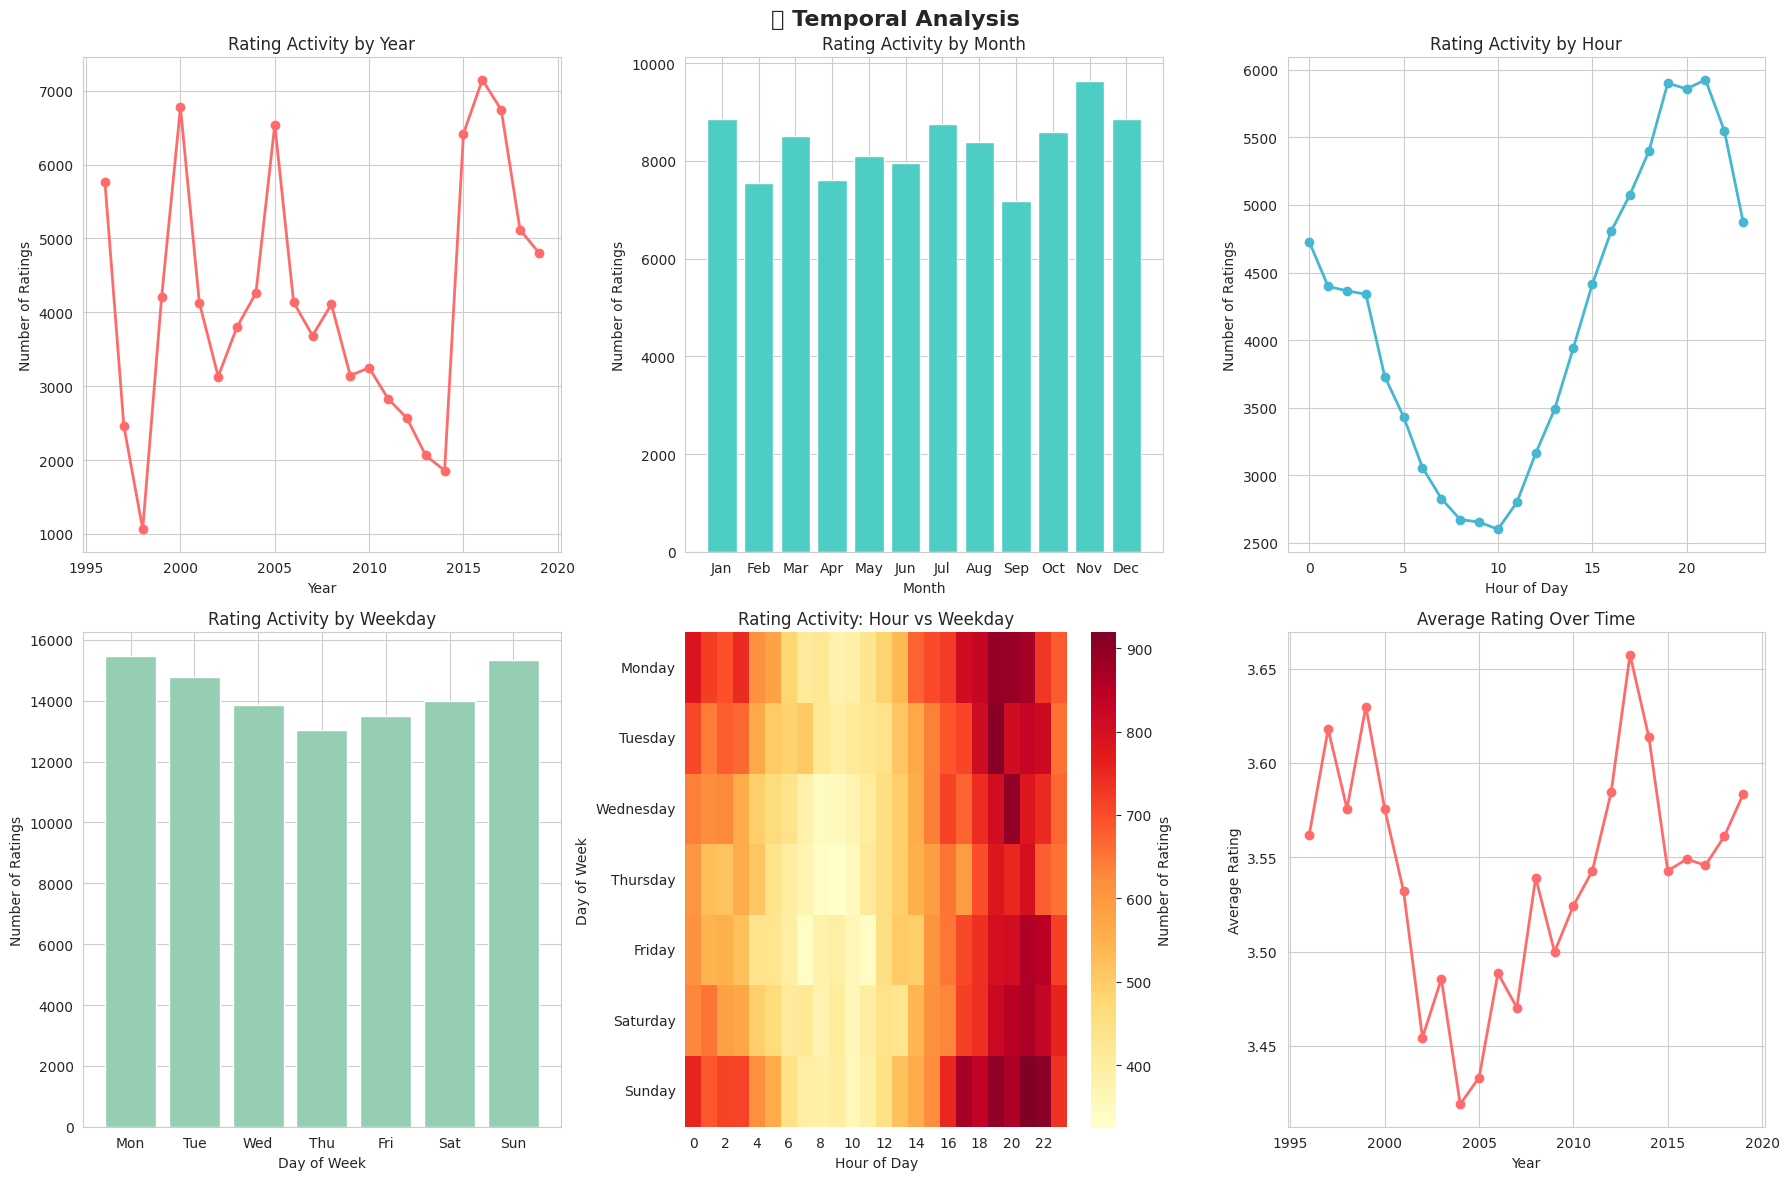

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("📅 Temporal Analysis", fontsize=16, fontweight="bold")

# 1. Ratings by year
yearly_ratings = ratings_sample.groupby("year").size()
axes[0, 0].plot(
    yearly_ratings.index,
    yearly_ratings.values,
    marker="o",
    color="#ff6b6b",
    linewidth=2,
)

axes[0, 0].set_title("Rating Activity by Year")
axes[0, 0].set_xlabel("Year")
axes[0, 0].set_ylabel("Number of Ratings")

# 2. Ratings by month
monthly_ratings = ratings_sample.groupby("month").size()
month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]

axes[0, 1].bar(range(1, 13), monthly_ratings.values, color="#4ecdc4")
axes[0, 1].set_title("Rating Activity by Month")
axes[0, 1].set_xlabel("Month")
axes[0, 1].set_ylabel("Number of Ratings")
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].set_xticklabels(month_names)

# 3. Ratings by hour
hourly_ratings = ratings_sample.groupby("hour").size()
axes[0, 2].plot(
    hourly_ratings.index,
    hourly_ratings.values,
    marker="o",
    color="#45b7d1",
    linewidth=2,
)

axes[0, 2].set_title("Rating Activity by Hour")
axes[0, 2].set_xlabel("Hour of Day")
axes[0, 2].set_ylabel("Number of Ratings")

# 4. Ratings by weekday
weekday_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
weekday_ratings = ratings_sample.groupby("weekday").size().reindex(weekday_order)

axes[1, 0].bar(range(7), weekday_ratings.values, color="#96ceb4")
axes[1, 0].set_title("Rating Activity by Weekday")
axes[1, 0].set_xlabel("Day of Week")
axes[1, 0].set_ylabel("Number of Ratings")
axes[1, 0].set_xticks(range(7))
axes[1, 0].set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])

# 5. Heatmap: Hour vs Weekday
hour_weekday = ratings_sample.groupby(["weekday", "hour"]).size().unstack(fill_value=0)
hour_weekday = hour_weekday.reindex(weekday_order)
sns.heatmap(
    hour_weekday, cmap="YlOrRd", ax=axes[1, 1], cbar_kws={"label": "Number of Ratings"}
)

axes[1, 1].set_title("Rating Activity: Hour vs Weekday")
axes[1, 1].set_xlabel("Hour of Day")
axes[1, 1].set_ylabel("Day of Week")

# 6. Average rating over time
yearly_avg_rating = ratings_sample.groupby("year")["rating"].mean()
axes[1, 2].plot(
    yearly_avg_rating.index,
    yearly_avg_rating.values,
    marker="o",
    color="#ff6b6b",
    linewidth=2,
)

axes[1, 2].set_title("Average Rating Over Time")
axes[1, 2].set_xlabel("Year")
axes[1, 2].set_ylabel("Average Rating")

plt.tight_layout()
plt.show()

## 6.0 Gene Analysis


In [20]:
movies["genres_list"] = movies["genres"].str.split("|")
all_genres = []
for genres in movies["genres_list"].dropna():
    all_genres.extend(genres)

In [21]:
genre_counts = pd.Series(all_genres).value_counts()

In [22]:
genre_ratings = []
for genre in genre_counts.head(15).index:
    genre_movies = movies[movies["genres"].str.contains(genre, na=False)]["movieId"]
    genre_movie_ratings = ratings_sample[ratings_sample["movieId"].isin(genre_movies)]

    if len(genre_movie_ratings) > 0:
        avg_rating = genre_movie_ratings["rating"].mean()
        count = len(genre_movie_ratings)
        genre_ratings.append({"genre": genre, "avg_rating": avg_rating, "count": count})

genre_ratings_df = pd.DataFrame(genre_ratings)

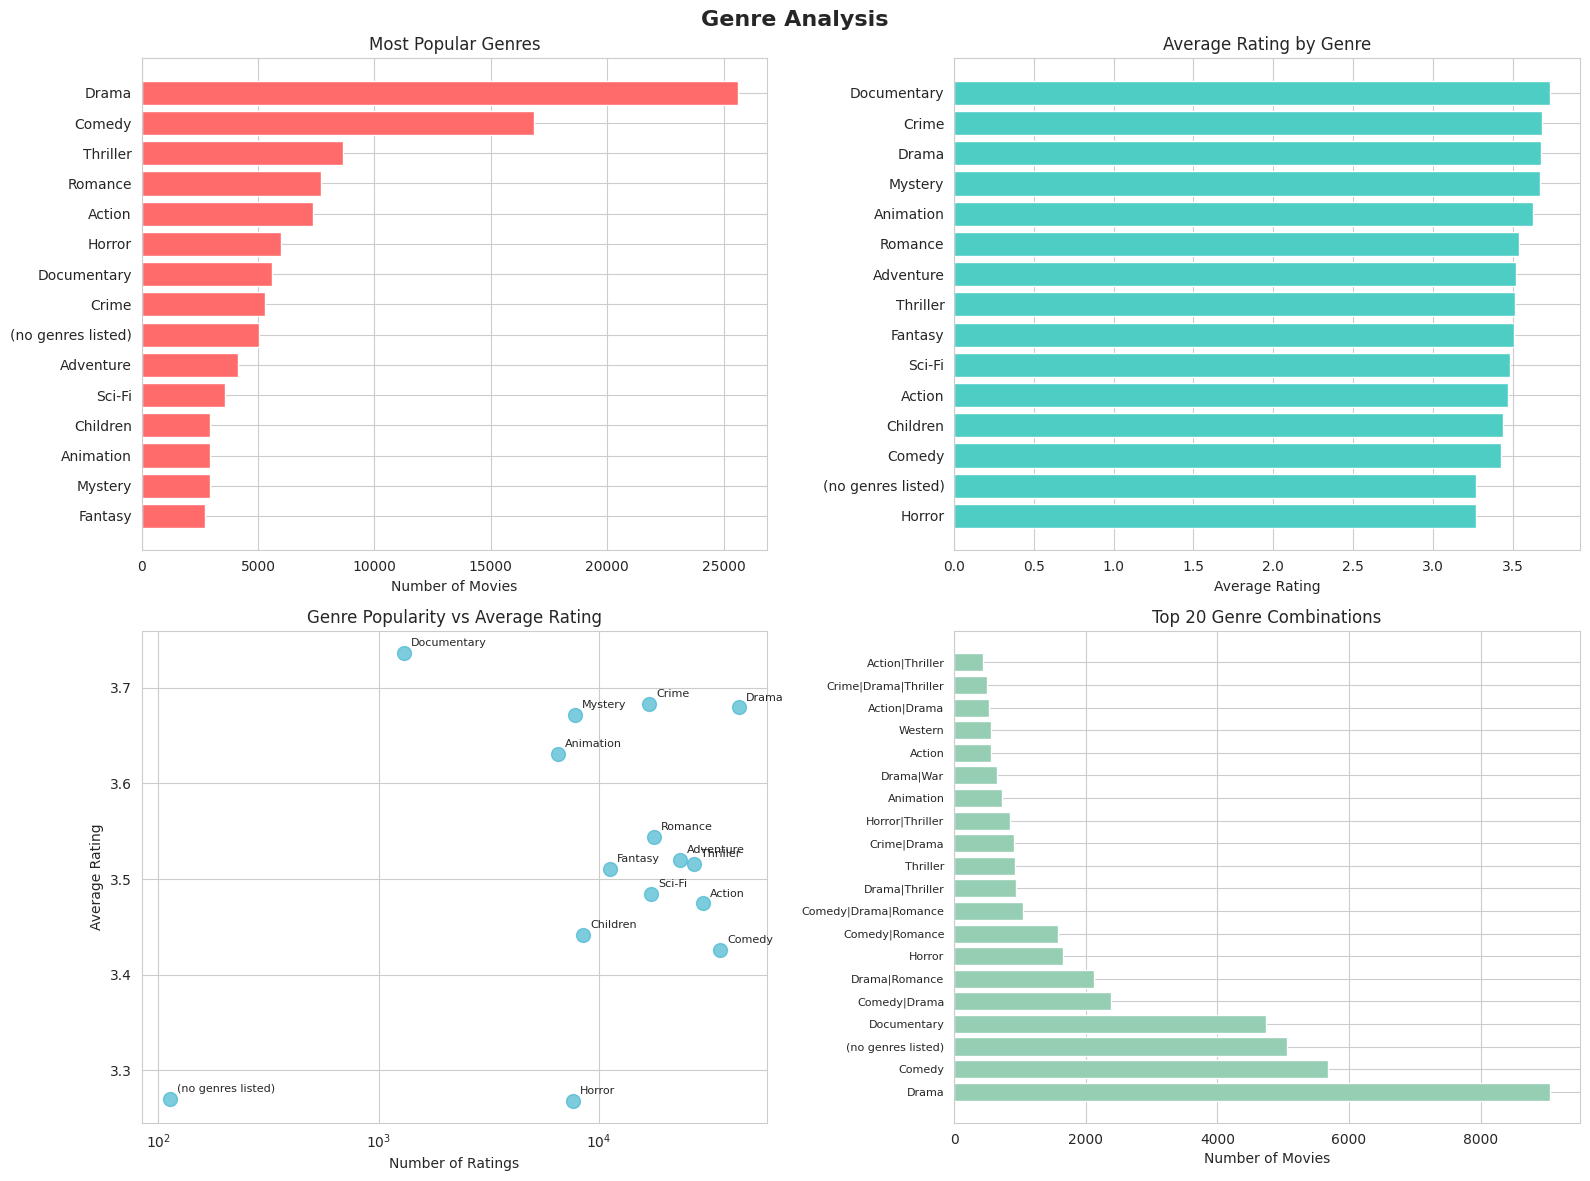

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Genre Analysis", fontsize=16, fontweight="bold")

# 1. Genre popularity
top_genres = genre_counts.head(15)
axes[0, 0].barh(range(len(top_genres)), top_genres.values, color="#ff6b6b")
axes[0, 0].set_title("Most Popular Genres")
axes[0, 0].set_xlabel("Number of Movies")
axes[0, 0].set_yticks(range(len(top_genres)))
axes[0, 0].set_yticklabels(top_genres.index)
axes[0, 0].invert_yaxis()

# 2. Genre ratings
genre_ratings_sorted = genre_ratings_df.sort_values("avg_rating", ascending=True)
axes[0, 1].barh(
    range(len(genre_ratings_sorted)),
    genre_ratings_sorted["avg_rating"],
    color="#4ecdc4",
)

axes[0, 1].set_title("Average Rating by Genre")
axes[0, 1].set_xlabel("Average Rating")
axes[0, 1].set_yticks(range(len(genre_ratings_sorted)))
axes[0, 1].set_yticklabels(genre_ratings_sorted["genre"])

# 3. Genre popularity vs rating scatter
axes[1, 0].scatter(
    genre_ratings_df["count"],
    genre_ratings_df["avg_rating"],
    s=100,
    alpha=0.7,
    c="#45b7d1",
)

axes[1, 0].set_title("Genre Popularity vs Average Rating")
axes[1, 0].set_xlabel("Number of Ratings")
axes[1, 0].set_ylabel("Average Rating")
axes[1, 0].set_xscale("log")

# Add genre labels to scatter plot
for idx, row in genre_ratings_df.iterrows():
    axes[1, 0].annotate(
        row["genre"],
        (row["count"], row["avg_rating"]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=8,
    )

# 4. Genre combinations analysis
genre_combinations = movies["genres"].value_counts().head(20)
axes[1, 1].barh(
    range(len(genre_combinations)), genre_combinations.values, color="#96ceb4"
)

axes[1, 1].set_title("Top 20 Genre Combinations")
axes[1, 1].set_xlabel("Number of Movies")
axes[1, 1].set_yticks(range(len(genre_combinations)))
axes[1, 1].set_yticklabels(
    [
        combo[:30] + "..." if len(combo) > 30 else combo
        for combo in genre_combinations.index
    ],
    fontsize=8,
)

plt.tight_layout()
plt.show()

## 7.0 Rating Patterns


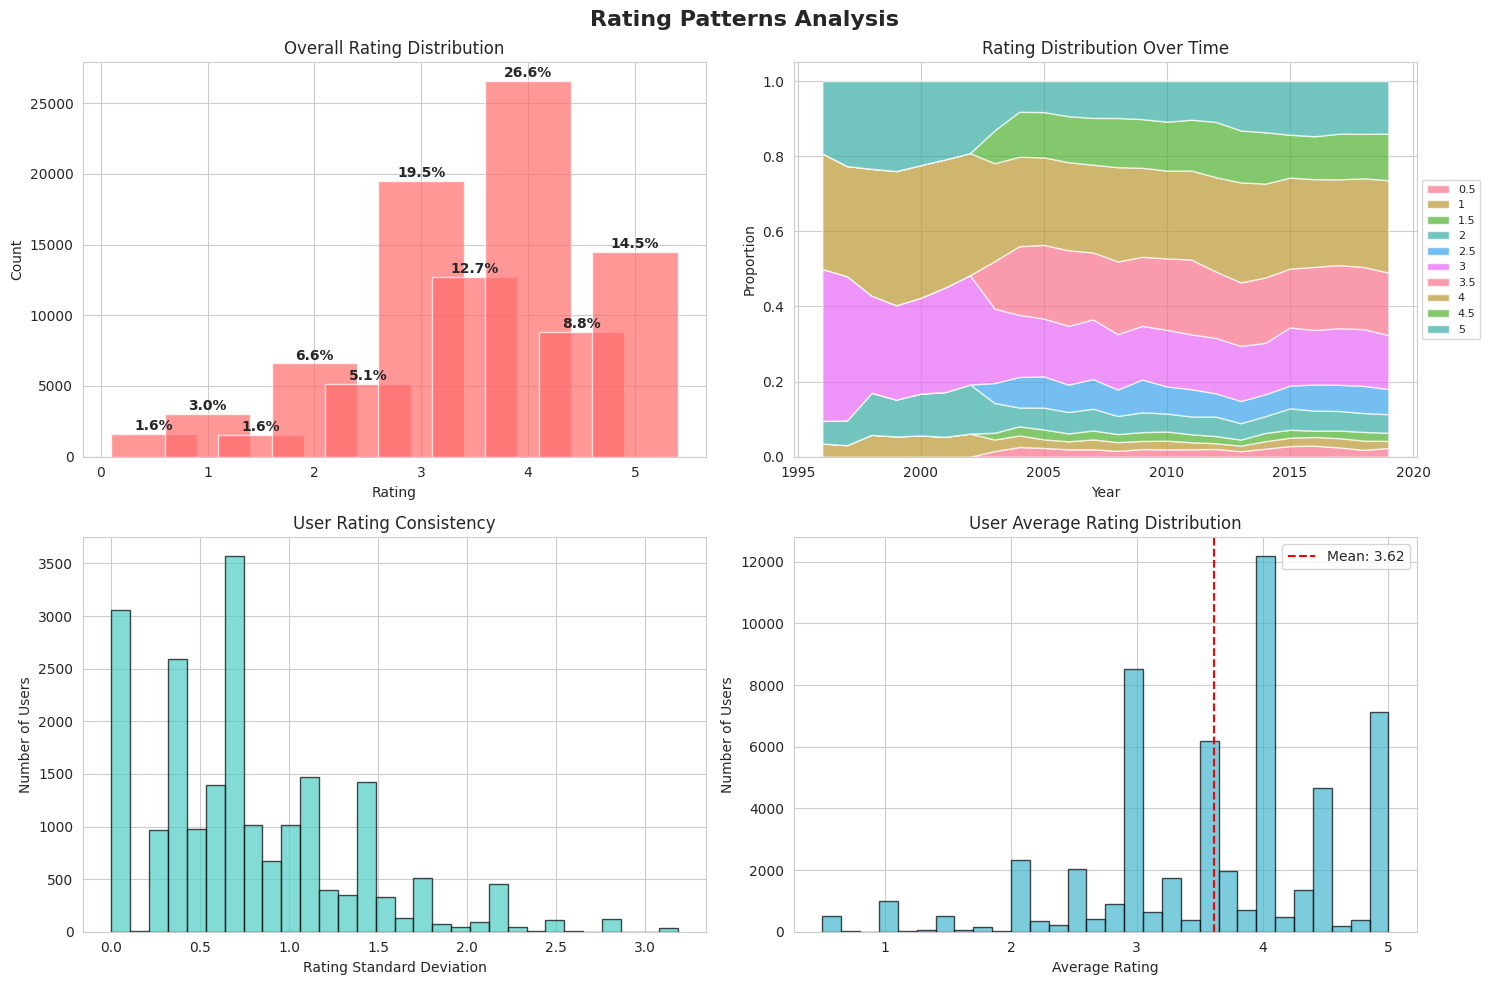

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Rating Patterns Analysis", fontsize=16, fontweight="bold")

# 1. Overall rating distribution
rating_dist = ratings_sample["rating"].value_counts().sort_index()
axes[0, 0].bar(rating_dist.index, rating_dist.values, color="#ff6b6b", alpha=0.7)

axes[0, 0].set_title("Overall Rating Distribution")
axes[0, 0].set_xlabel("Rating")
axes[0, 0].set_ylabel("Count")

# Add percentages on bars
for rating, count in rating_dist.items():
    percentage = (count / len(ratings_sample)) * 100
    axes[0, 0].text(
        rating,
        count + max(rating_dist.values) * 0.01,
        f"{percentage:.1f}%",
        ha="center",
        fontweight="bold",
    )

# 2. Rating distribution by year
rating_by_year = ratings_sample.pivot_table(
    index="year", columns="rating", values="userId", aggfunc="count", fill_value=0
)

rating_by_year_pct = rating_by_year.div(rating_by_year.sum(axis=1), axis=0)
axes[0, 1].stackplot(
    rating_by_year_pct.index,
    rating_by_year_pct[0.5],
    rating_by_year_pct[1.0],
    rating_by_year_pct[1.5],
    rating_by_year_pct[2.0],
    rating_by_year_pct[2.5],
    rating_by_year_pct[3.0],
    rating_by_year_pct[3.5],
    rating_by_year_pct[4.0],
    rating_by_year_pct[4.5],
    rating_by_year_pct[5.0],
    labels=[
        "0.5",
        "1",
        "1.5",
        "2",
        "2.5",
        "3",
        "3.5",
        "4",
        "4.5",
        "5",
    ],
    alpha=0.7,
)
axes[0, 1].set_title("Rating Distribution Over Time")
axes[0, 1].set_xlabel("Year")
axes[0, 1].set_ylabel("Proportion")
axes[0, 1].legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=8)

# 3. User rating behavior
user_rating_std = ratings_sample.groupby("userId")["rating"].std().dropna()
axes[1, 0].hist(user_rating_std, bins=30, alpha=0.7, color="#4ecdc4", edgecolor="black")
axes[1, 0].set_title("User Rating Consistency")
axes[1, 0].set_xlabel("Rating Standard Deviation")
axes[1, 0].set_ylabel("Number of Users")

# 4. Rating bias analysis
user_avg_ratings = ratings_sample.groupby("userId")["rating"].mean()
axes[1, 1].hist(
    user_avg_ratings, bins=30, alpha=0.7, color="#45b7d1", edgecolor="black"
)

axes[1, 1].set_title("User Average Rating Distribution")
axes[1, 1].set_xlabel("Average Rating")
axes[1, 1].set_ylabel("Number of Users")
axes[1, 1].axvline(
    user_avg_ratings.mean(),
    color="red",
    linestyle="--",
    label=f"Mean: {user_avg_ratings.mean():.2f}",
)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 8.0 Cold Start and Recommendation Insights


In [25]:
new_users = user_stats[user_stats["num_ratings"] <= 5]
sparse_users = user_stats[user_stats["num_ratings"] <= 20]
popular_movies = movie_stats[movie_stats["num_ratings"] >= 100]
niche_movies = movie_stats[movie_stats["num_ratings"] <= 10]

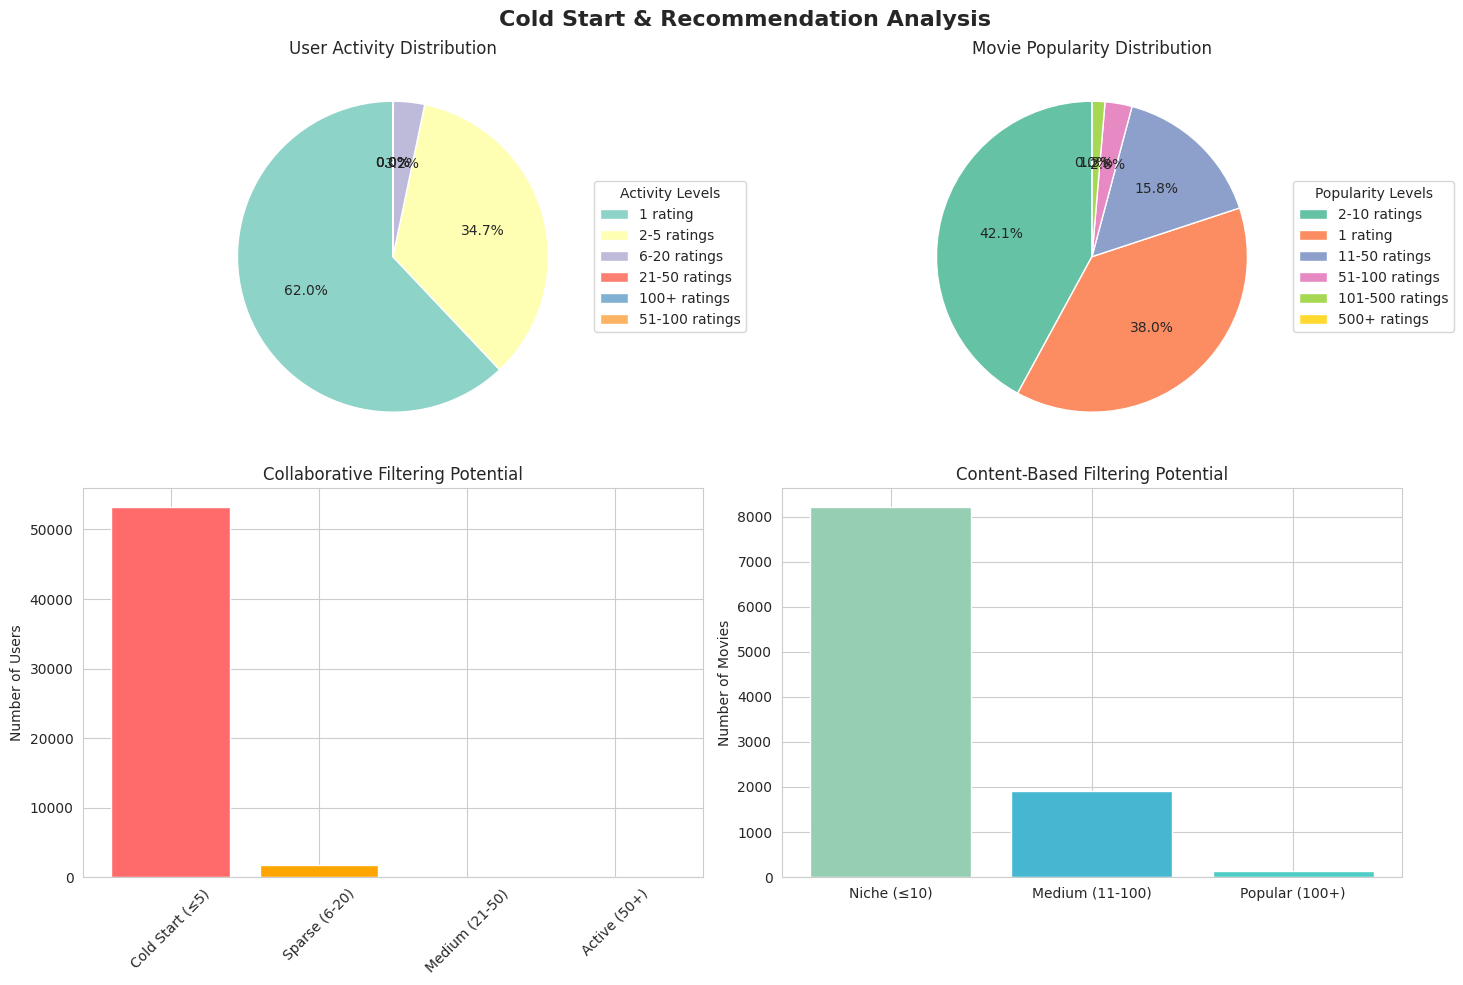

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Cold Start & Recommendation Analysis", fontsize=16, fontweight="bold")

# 1. User activity distribution - FIXED
user_activity_bins = [0, 1, 5, 20, 50, 100, float("inf")]
user_activity_labels = [
    "1 rating",
    "2-5 ratings",
    "6-20 ratings",
    "21-50 ratings",
    "51-100 ratings",
    "100+ ratings",
]
user_activity_counts = pd.cut(
    user_stats["num_ratings"],
    bins=user_activity_bins,
    labels=user_activity_labels,
    include_lowest=True,
).value_counts()

wedges, texts, autotexts = axes[0, 0].pie(
    user_activity_counts.values,
    autopct="%1.1f%%",
    startangle=90,
    colors=plt.cm.Set3.colors,
)
axes[0, 0].set_title("User Activity Distribution")
axes[0, 0].legend(
    wedges,
    user_activity_counts.index,
    title="Activity Levels",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
)

# 2. Movie popularity distribution - FIXED
movie_popularity_bins = [0, 1, 10, 50, 100, 500, float("inf")]
movie_popularity_labels = [
    "1 rating",
    "2-10 ratings",
    "11-50 ratings",
    "51-100 ratings",
    "101-500 ratings",
    "500+ ratings",
]
movie_popularity_counts = pd.cut(
    movie_stats["num_ratings"],
    bins=movie_popularity_bins,
    labels=movie_popularity_labels,
    include_lowest=True,
).value_counts()

wedges2, texts2, autotexts2 = axes[0, 1].pie(
    movie_popularity_counts.values,
    autopct="%1.1f%%",
    startangle=90,
    colors=plt.cm.Set2.colors,
)
axes[0, 1].set_title("Movie Popularity Distribution")
axes[0, 1].legend(
    wedges2,
    movie_popularity_counts.index,
    title="Popularity Levels",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
)

# 3. Collaborative filtering potential
cf_data = {
    "Cold Start (≤5)": len(new_users),
    "Sparse (6-20)": len(sparse_users) - len(new_users),
    "Medium (21-50)": len(
        user_stats[(user_stats["num_ratings"] > 20) & (user_stats["num_ratings"] <= 50)]
    ),
    "Active (50+)": len(user_stats[user_stats["num_ratings"] > 50]),
}

axes[1, 0].bar(
    cf_data.keys(), cf_data.values(), color=["#ff6b6b", "#ffa500", "#45b7d1", "#4ecdc4"]
)
axes[1, 0].set_title("Collaborative Filtering Potential")
axes[1, 0].set_ylabel("Number of Users")
axes[1, 0].tick_params(axis="x", rotation=45)

# 4. Content-based filtering potential
content_data = {
    "Niche (≤10)": len(niche_movies),
    "Medium (11-100)": len(
        movie_stats[
            (movie_stats["num_ratings"] > 10) & (movie_stats["num_ratings"] <= 100)
        ]
    ),
    "Popular (100+)": len(popular_movies),
}

axes[1, 1].bar(
    content_data.keys(), content_data.values(), color=["#96ceb4", "#45b7d1", "#4ecdc4"]
)
axes[1, 1].set_title("Content-Based Filtering Potential")
axes[1, 1].set_ylabel("Number of Movies")

plt.tight_layout()
plt.show()

## 9.0 Tags Analysis


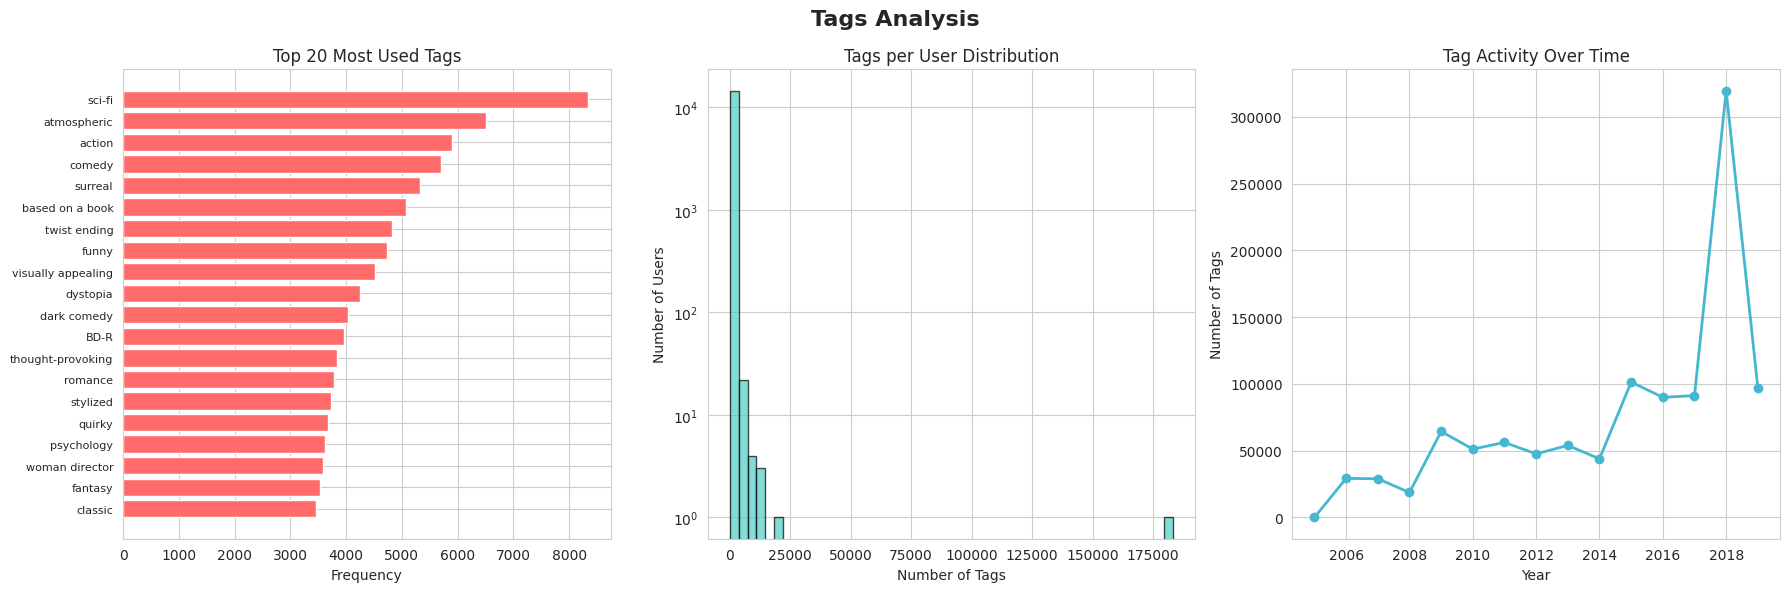

In [27]:
if not tags.empty:
    # Tags visualizations
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle("Tags Analysis", fontsize=16, fontweight="bold")

    # 1. Top tags
    top_tags = tags["tag"].value_counts().head(20)
    axes[0].barh(range(len(top_tags)), top_tags.values, color="#ff6b6b")
    axes[0].set_title("Top 20 Most Used Tags")
    axes[0].set_xlabel("Frequency")
    axes[0].set_yticks(range(len(top_tags)))
    axes[0].set_yticklabels(top_tags.index, fontsize=8)
    axes[0].invert_yaxis()

    # 2. Tag activity by users
    user_tag_counts = tags.groupby("userId").size()
    axes[1].hist(
        user_tag_counts, bins=50, alpha=0.7, color="#4ecdc4", edgecolor="black"
    )

    axes[1].set_title("Tags per User Distribution")
    axes[1].set_xlabel("Number of Tags")
    axes[1].set_ylabel("Number of Users")
    axes[1].set_yscale("log")

    # 3. Tag activity over time
    tags["datetime"] = pd.to_datetime(tags["timestamp"], unit="s")
    tags["year"] = tags["datetime"].dt.year
    yearly_tags = tags.groupby("year").size()
    axes[2].plot(
        yearly_tags.index, yearly_tags.values, marker="o", color="#45b7d1", linewidth=2
    )

    axes[2].set_title("Tag Activity Over Time")
    axes[2].set_xlabel("Year")
    axes[2].set_ylabel("Number of Tags")

    plt.tight_layout()
    plt.show()

## 10.0 Correlation Analysis


In [28]:
correlation_data = ratings_sample.merge(movies[["movieId", "title"]], on="movieId")

In [29]:
current_year = datetime.now().year
movie_years = movies["title"].str.extract(r"\((\d{4})\)")[0].astype(float)
movies["movie_age"] = current_year - movie_years

In [30]:
correlation_features = (
    ratings_sample.merge(movies[["movieId", "movie_age"]], on="movieId")
    .merge(
        movie_stats[["num_ratings", "avg_rating"]],
        left_on="movieId",
        right_index=True,
        suffixes=("", "_movie"),
    )
    .merge(
        user_stats[["num_ratings", "avg_rating"]],
        left_on="userId",
        right_index=True,
        suffixes=("_movie", "_user"),
    )
)

In [31]:
corr_columns = [
    "rating",
    "movie_age",
    "num_ratings_movie",
    "avg_rating_movie",
    "num_ratings_user",
    "avg_rating_user",
    "hour",
    "year",
]

correlation_matrix = correlation_features[corr_columns].corr()

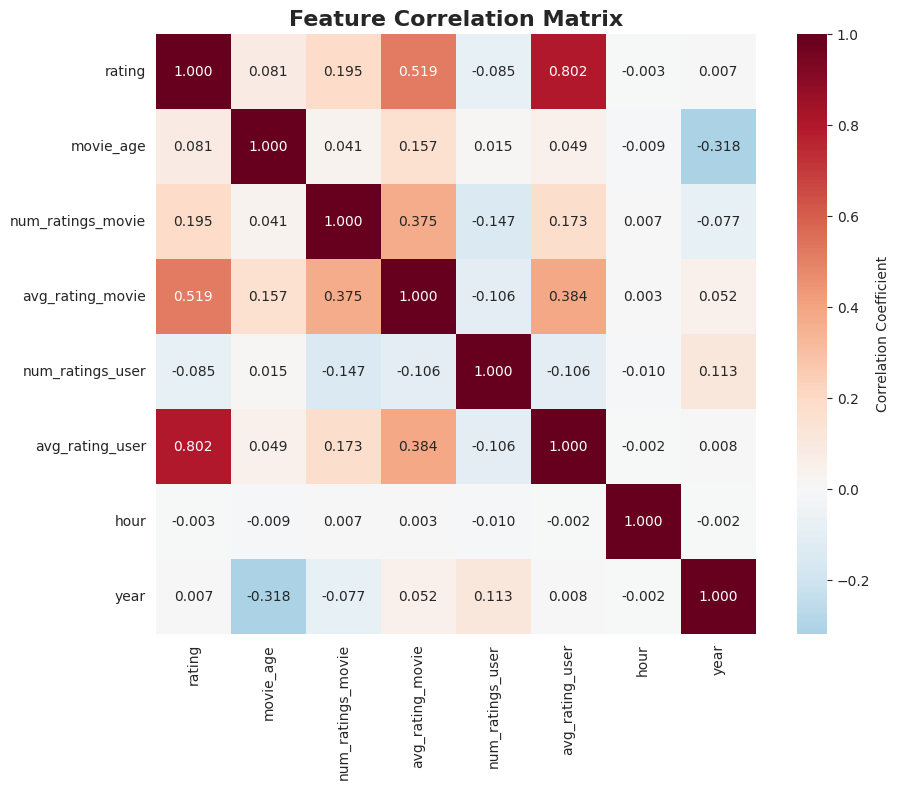

In [32]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="RdBu_r",
    center=0,
    square=True,
    fmt=".3f",
    cbar_kws={"label": "Correlation Coefficient"},
)

plt.title("Feature Correlation Matrix", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

## 11.0 Recommendation Engine Performance Insights


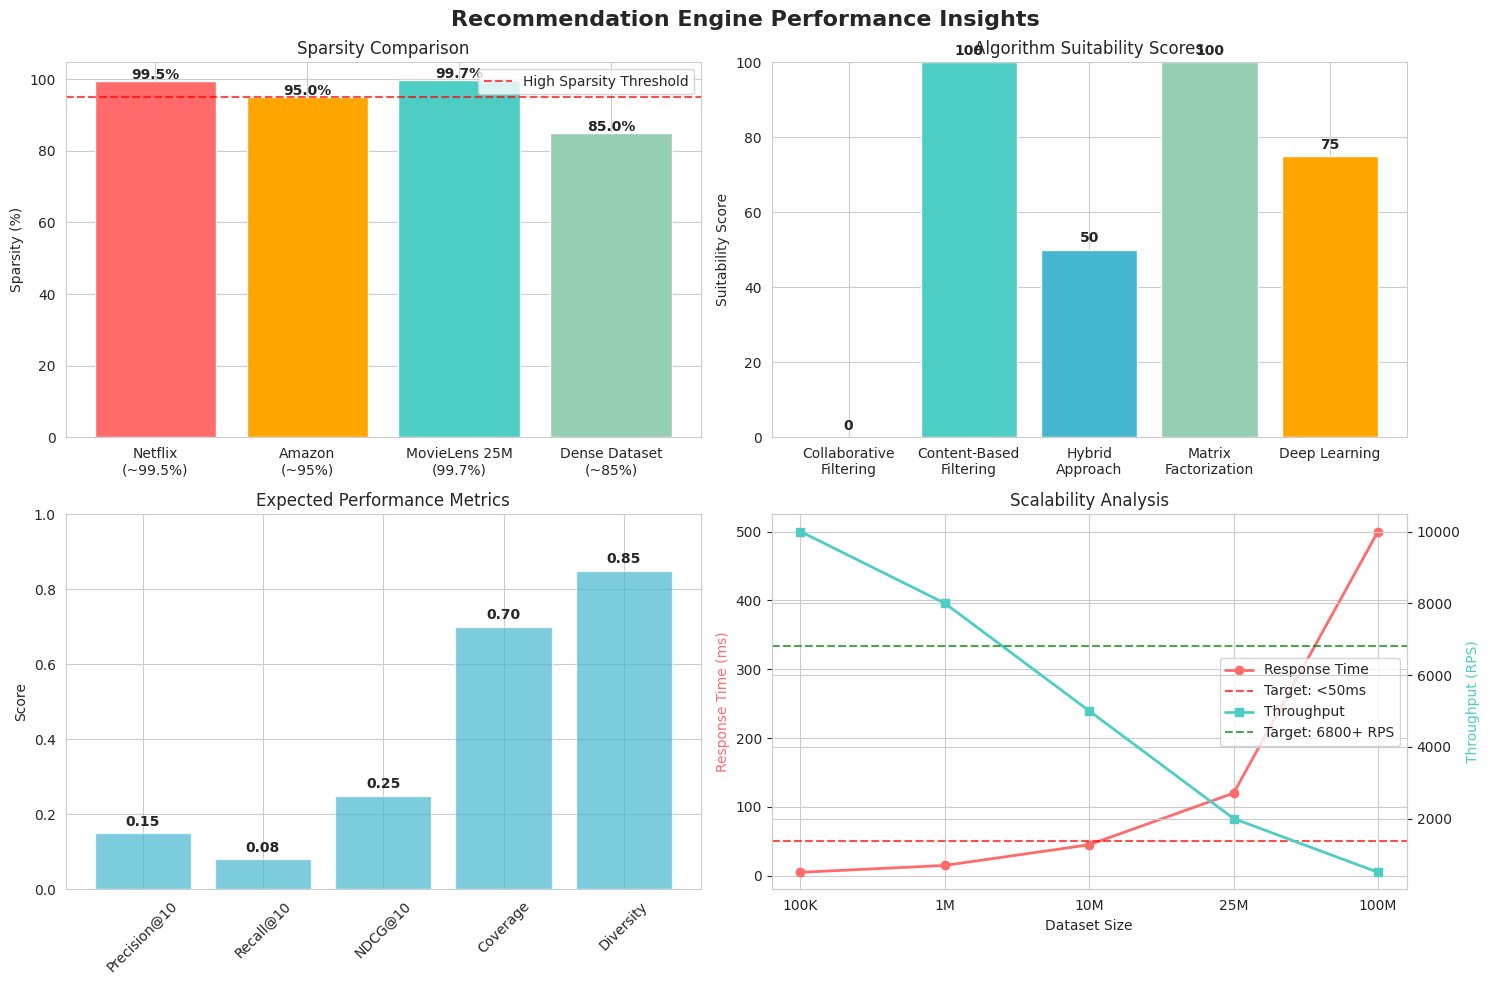

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(
    "Recommendation Engine Performance Insights", fontsize=16, fontweight="bold"
)

# 1. Data sparsity visualization
sparsity_levels = {
    "Very Sparse (>99%)": 0.99,
    "Sparse (95-99%)": 0.95,
    "Medium (90-95%)": 0.90,
    "Dense (<90%)": 0.0,
}

our_sparsity = sparsity * 100
sparsity_comparison = [99.5, 95.0, our_sparsity, 85.0]
sparsity_labels = [
    "Netflix\n(~99.5%)",
    "Amazon\n(~95%)",
    f"MovieLens 25M\n({our_sparsity:.1f}%)",
    "Dense Dataset\n(~85%)",
]

bars = axes[0, 0].bar(
    sparsity_labels,
    sparsity_comparison,
    color=["#ff6b6b", "#ffa500", "#4ecdc4", "#96ceb4"],
)

axes[0, 0].set_title("Sparsity Comparison")
axes[0, 0].set_ylabel("Sparsity (%)")
axes[0, 0].axhline(
    y=95, color="red", linestyle="--", alpha=0.7, label="High Sparsity Threshold"
)

axes[0, 0].legend()
for bar, value in zip(bars, sparsity_comparison):
    axes[0, 0].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f"{value:.1f}%",
        ha="center",
        fontweight="bold",
    )

# 2. Algorithm suitability scores
algorithms = [
    "Collaborative\nFiltering",
    "Content-Based\nFiltering",
    "Hybrid\nApproach",
    "Matrix\nFactorization",
    "Deep Learning",
]

cf_score = min(
    100, (len(user_stats[user_stats["num_ratings"] >= 20]) / len(user_stats)) * 100
)
content_score = (movies["genres"].notna().sum() / len(movies)) * 100
hybrid_score = (cf_score + content_score) / 2
mf_score = min(100, (ratings.shape[0] / 1000000) * 20)
dl_score = min(100, (ratings.shape[0] / 10000000) * 30)

suitability_scores = [cf_score, content_score, hybrid_score, mf_score, dl_score]
bars = axes[0, 1].bar(
    algorithms,
    suitability_scores,
    color=["#ff6b6b", "#4ecdc4", "#45b7d1", "#96ceb4", "#ffa500"],
)

axes[0, 1].set_title("Algorithm Suitability Scores")
axes[0, 1].set_ylabel("Suitability Score")
axes[0, 1].set_ylim(0, 100)

for bar, score in zip(bars, suitability_scores):
    axes[0, 1].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 2,
        f"{score:.0f}",
        ha="center",
        fontweight="bold",
    )

# 3. Expected performance metrics
metrics = ["Precision@10", "Recall@10", "NDCG@10", "Coverage", "Diversity"]
expected_values = [0.15, 0.08, 0.25, 0.70, 0.85]

axes[1, 0].bar(metrics, expected_values, color="#45b7d1", alpha=0.7)
axes[1, 0].set_title("Expected Performance Metrics")
axes[1, 0].set_ylabel("Score")
axes[1, 0].set_ylim(0, 1)
axes[1, 0].tick_params(axis="x", rotation=45)

for i, (metric, value) in enumerate(zip(metrics, expected_values)):
    axes[1, 0].text(i, value + 0.02, f"{value:.2f}", ha="center", fontweight="bold")

# 4. Scalability analysis
data_sizes = ["100K", "1M", "10M", "25M", "100M"]
response_times = [5, 15, 45, 120, 500]  # Expected response times in ms
throughput = [10000, 8000, 5000, 2000, 500]  # Expected RPS

ax1 = axes[1, 1]
ax2 = ax1.twinx()

line1 = ax1.plot(
    data_sizes,
    response_times,
    "o-",
    color="#ff6b6b",
    linewidth=2,
    label="Response Time",
)

line2 = ax2.plot(
    data_sizes, throughput, "s-", color="#4ecdc4", linewidth=2, label="Throughput"
)

ax1.set_title("Scalability Analysis")
ax1.set_xlabel("Dataset Size")
ax1.set_ylabel("Response Time (ms)", color="#ff6b6b")
ax2.set_ylabel("Throughput (RPS)", color="#4ecdc4")
ax1.axhline(y=50, color="red", linestyle="--", alpha=0.7, label="Target: <50ms")
ax2.axhline(y=6800, color="green", linestyle="--", alpha=0.7, label="Target: 6800+ RPS")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="center right")

plt.tight_layout()
plt.show()